In [1]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D, DepthwiseConv2D, Reshape
import os
from shutil import copyfile
from tensorflow.keras.models import load_model
from tensorflow.python.keras.utils.generic_utils import CustomObjectScope

In [2]:
def relu6(x):
    return K.relu(x, max_value=6)

class DataGen(keras.utils.Sequence):  #读取数据
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#一次训练样本数
        self.image_size = image_size#图片大小
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) + ".jpg"#原图
        mask_path = os.path.join(self.path, "masks", id_name) + "_segmentation.png"#分割图
        
        ## Reading Image
    
        image = cv2.imread(image_path,1)#加载彩色图片
        image = cv2.resize(image, (self.image_size, self.image_size))#调整大小
        mask = np.zeros((self.image_size, self.image_size, 1))#128*128*1
        _mask = cv2.imread(mask_path, -1)#cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))#调整大小
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)#选择最大值
        
        
        ## 图像进行归一化，范围为[0, 1]
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask   #返回数组
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 128
path = "./datasets/test/"
train_path = "./datasets/test/images"
batch_size = 20   #一次训练样本数

## Training Ids
train_ids = []
for files in os.walk(train_path):#遍历目录
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]
train_ids = [i.split('.', 1)[0] for i in train_ids]#去.jpg后缀

In [7]:
def read_model():
    model = load_model('U-Net_Model.h5', custom_objects={'relu6': keras.layers.ReLU(6.), 'DepthwiseConv2D': keras.layers.DepthwiseConv2D})
    return model

In [8]:
#for i in range(0,10):
    gen = DataGen(train_ids, path,10,128)
    x, y = gen.__getitem__(0)
    model = read_model()
    result = model.predict(x)
    
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

平均:
0.7647926530680811
最差:
0.7011115162568091


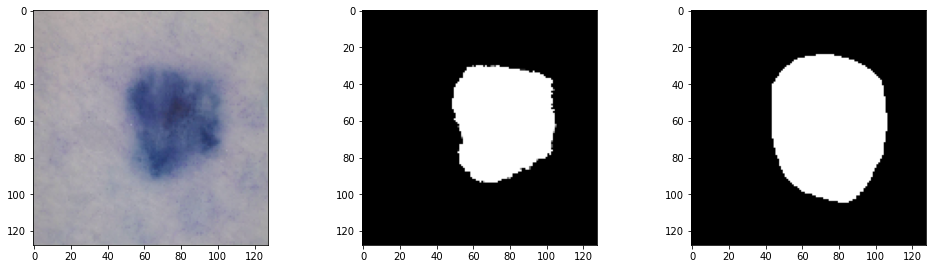

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

mean_jaccard, thresholded_jaccard = compute_jaccard(y, result)
print("平均:")
print(mean_jaccard)
print("最差:")
print(thresholded_jaccard)